In [37]:
# Import TensorFlow and other necessary libraries:

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [38]:
# In this dataset, there are roughly 3,700 images of flowers. Five subdirectories, one for each class, are present in the dataset:
# flower_photo/
# daisy/
# dandelion/
# roses/
# sunflowers/
# tulips/

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [39]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


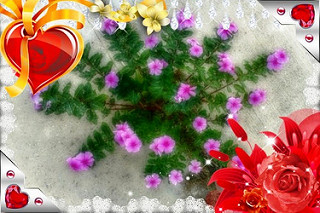

In [40]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

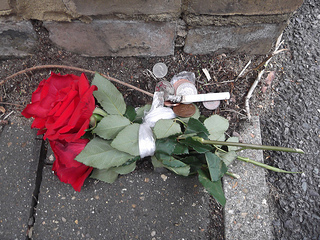

In [41]:
PIL.Image.open(str(roses[1]))

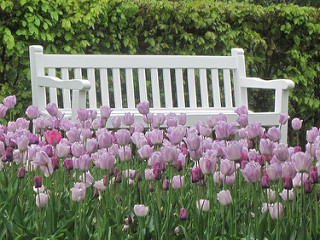

In [42]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

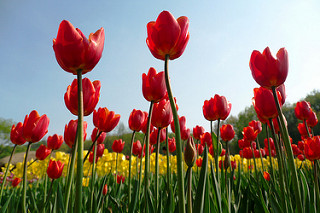

In [43]:
PIL.Image.open(str(tulips[1]))

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
# Employ the useful tf.keras.utils.image_dataset_from_directory tool to 
# load these photos from disc. With just a few lines of code, you can go from a 
# disc directory of photos to a tf.data.Dataset. By visiting the Load and 
# preprocess photos lesson.

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [46]:
# Validation split during model development. 20% of the photos used for validation and 80% for training.

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [47]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


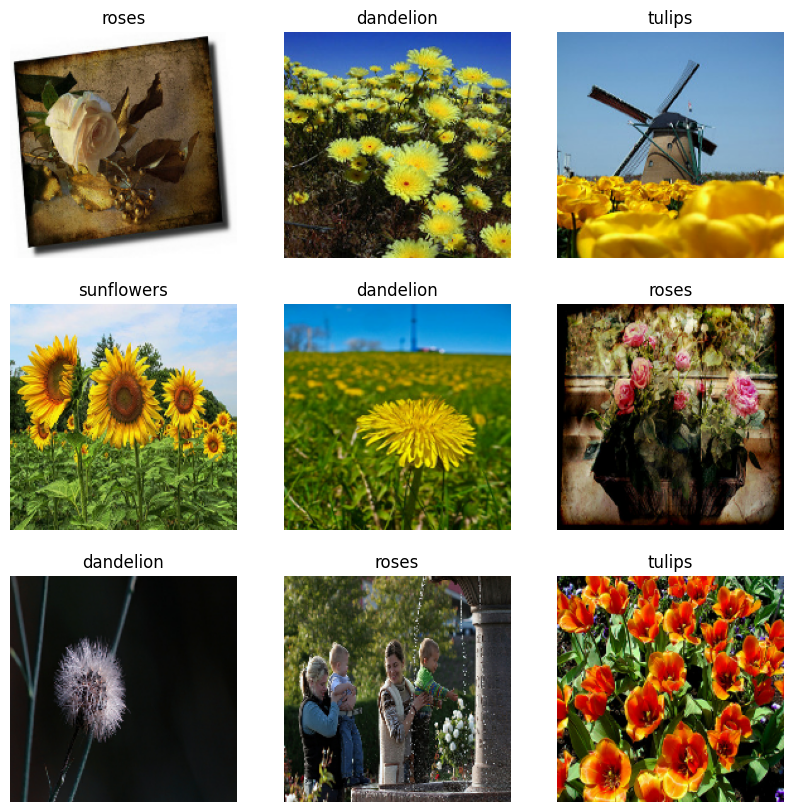

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [49]:
# pass these datasets to the Keras Model.fit method for training . we can 
# also manually iterate over the dataset and retrieve batches of images

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
# The RGB channel values are in the [0, 255] range. This is not ideal for a 
# neural network; in general you should seek to make your input values small.
# Here, you will standardize values to be in the [0, 1] range by 
# using tf.keras.layers.Rescaling

normalization_layer = layers.Rescaling(1./255)

In [52]:
# can apply it to the dataset by calling Dataset.map

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [53]:
# The Keras Sequential model consists of three convolution blocks 
# (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D)
# in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 
# 128 units on top of it that is activated by a ReLU activation function ('relu').

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [54]:
 # choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.
 # SparseCategoricalCrossentropy loss function. To view training and 
 # validation accuracy for each training epoch, pass the metrics argument to Model.compile
 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [56]:
# Train the model for 10 epochs with the Keras Model.fit method

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 114s 1s/step - loss: 1.3070 - accuracy: 0.4384 - val_loss: 1.0823 - val_accuracy: 0.5627
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 0.9625 - accuracy: 0.6287 - val_loss: 0.9765 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 109s 1s/step - loss: 0.7996 - accuracy: 0.6969 - val_loss: 0.9530 - val_accuracy: 0.6335
Epoch 4/10
92/92 [==============================] - 107s 1s/step - loss: 0.6098 - accuracy: 0.7772 - val_loss: 0.9805 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 111s 1s/step - loss: 0.4131 - accuracy: 0.8559 - val_loss: 1.0013 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 105s 1s/step - loss: 0.2711 - accuracy: 0.9009 - val_loss: 1.1458 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 107s 1s/step - loss: 0.1331 - accuracy: 0.9615 - val_loss: 1.4817 - val_accuracy: 0.6185
Epoch 8/10
92

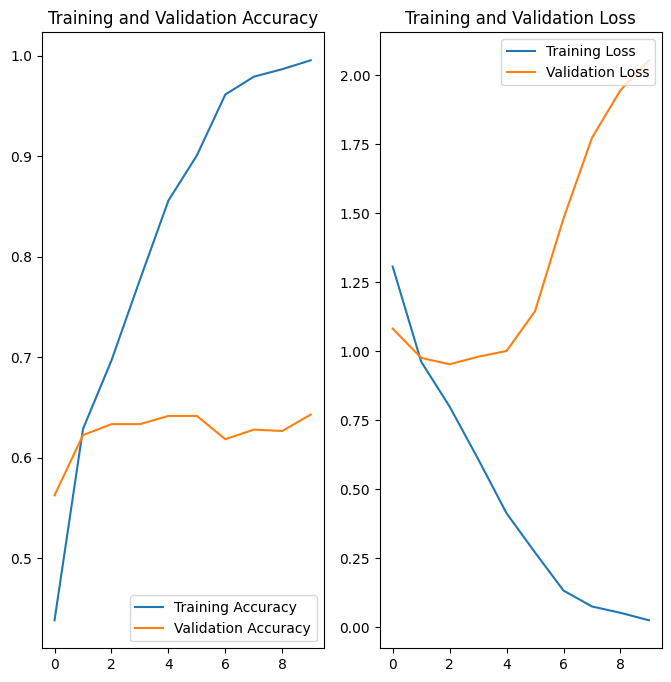

In [57]:
# Create plots of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [58]:
# ata augmentation using the following Keras preprocessing layers: 
# tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

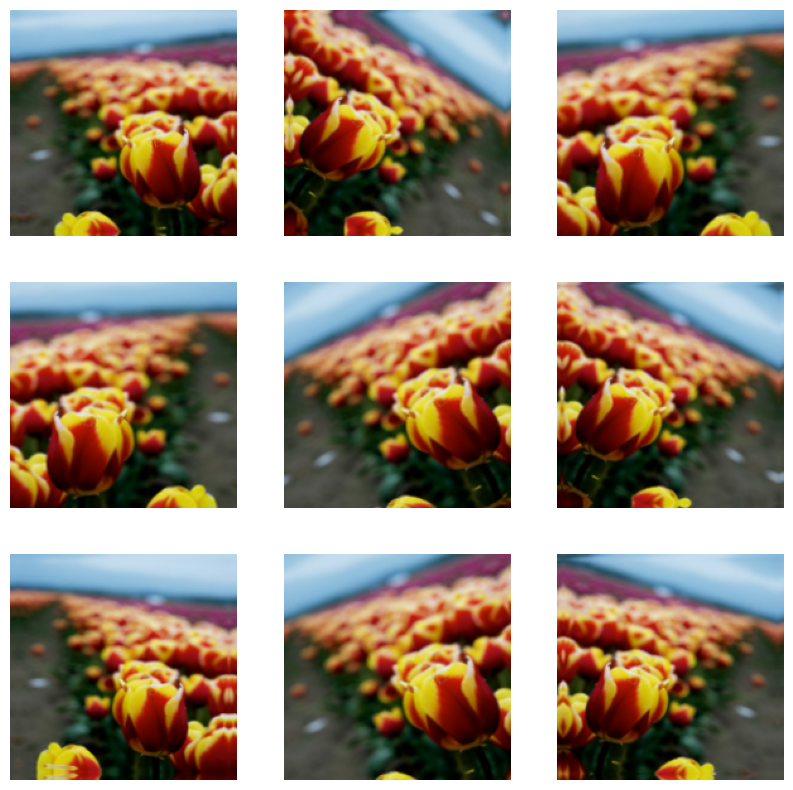

In [59]:
# Visualize a few augmented examples by applying data augmentation to the same image several times:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [60]:
# Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [63]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 126s 1s/step - loss: 1.3090 - accuracy: 0.4455 - val_loss: 1.1549 - val_accuracy: 0.5518
Epoch 2/15
92/92 [==============================] - 129s 1s/step - loss: 1.0039 - accuracy: 0.6097 - val_loss: 0.9350 - val_accuracy: 0.6349
Epoch 3/15
92/92 [==============================] - 124s 1s/step - loss: 0.9153 - accuracy: 0.6424 - val_loss: 0.9294 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 128s 1s/step - loss: 0.8582 - accuracy: 0.6662 - val_loss: 0.8292 - val_accuracy: 0.6744
Epoch 5/15
92/92 [==============================] - 127s 1s/step - loss: 0.7894 - accuracy: 0.7084 - val_loss: 0.8273 - val_accuracy: 0.6798
Epoch 6/15
92/92 [==============================] - 128s 1s/step - loss: 0.7381 - accuracy: 0.7228 - val_loss: 0.7465 - val_accuracy: 0.7016
Epoch 7/15
92/92 [==============================] - 123s 1s/step - loss: 0.7180 - accuracy: 0.7296 - val_loss: 0.7807 - val_accuracy: 0.6880
Epoch 8/15
92

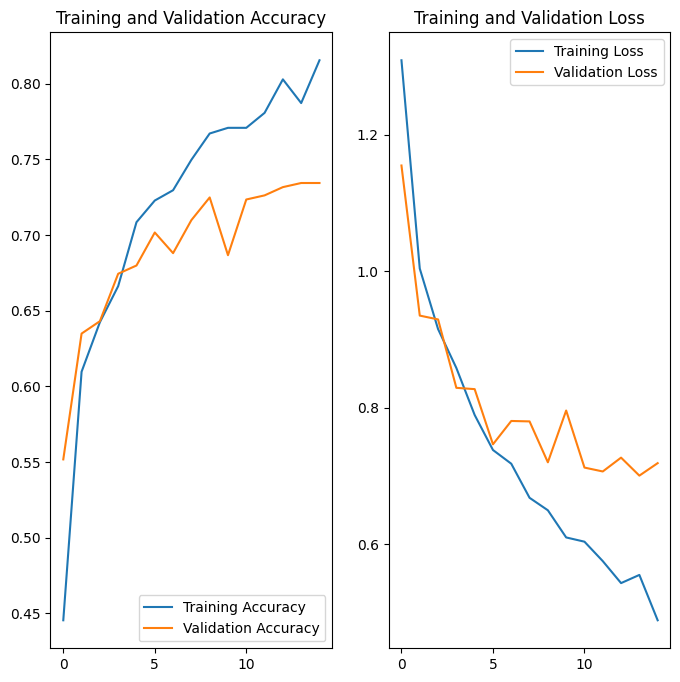

In [64]:
# data augmentation and tf.keras.layers.Dropout, there is less overfitting 
# than before, and training and validation accuracy are closer aligned

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
# Use your model to classify an image that wasn't included in the training or validation sets

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 108ms/step
This image most likely belongs to sunflowers with a 99.04 percent confidence.


In [66]:
# Convert the model.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [67]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [68]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_4_input'], 'outputs': ['outputs']}}

In [69]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [74]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 93.32 percent confidence.
